# Exemplo de uso

## Parte 3: Cálculo das métricas.

Importando as bilbiotecas que serão utilizadas.

In [35]:
import sys
sys.path.insert(0, '../lib')

import pandas as pd
import ast
import matplotlib.pyplot as plt
from lda_discourse_evolution import MetricsCalculator
import numpy as np
from typing import List

Lendo o dataset gerado na etapa anterior.

In [36]:
df = pd.read_csv('../dados/tweets_prefeitos_2020_preprocessado_com_td.csv.gzip', compression='gzip')
df['created_at'] = pd.to_datetime(df['created_at'])
df['td'] = df['td'].apply(ast.literal_eval)

Instanciando um objeto da classe que calcula as métricas.

In [37]:
metrics_calculator = MetricsCalculator()

## Analisando a proporção de tópicos

Gerando gráficos com a proporção de tópicos ao longo do tempo

In [38]:
df['yyyy-mm'] = df['created_at'].dt.strftime('%Y-%m')

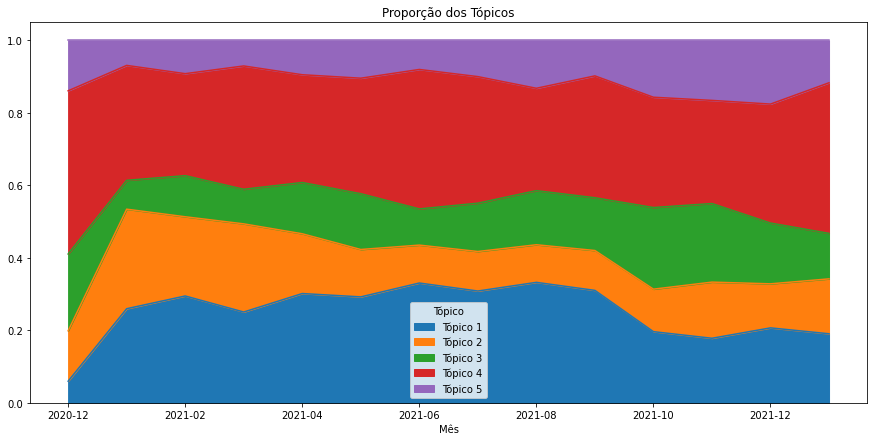

In [39]:
df_topics_count = df.groupby(['yyyy-mm', 'topic_label'])['topic_num'].count().unstack(level=1)
df_topics_count.divide(df_topics_count.sum(axis=1), axis=0).plot.area(title = 'Proporção dos Tópicos', xlabel='Mês', figsize=(15,7))
plt.legend(title='Tópico')

Gerando gráficos com a proporção de tópicos ao longo do tempo para um grupo específico.

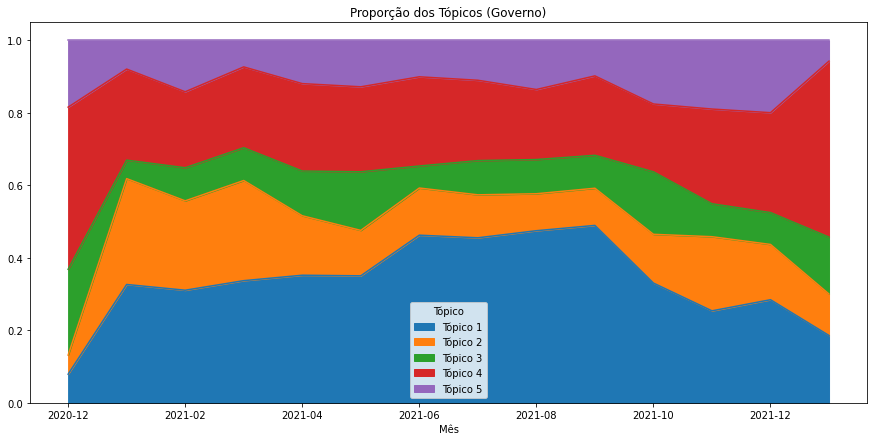

In [40]:
position = 'Governo'

df_topics_count = df[df['government_or_opposition_position'] == position].groupby(['yyyy-mm', 'topic_label'])['topic_num'].count().unstack(level=1)
df_topics_count.divide(df_topics_count.sum(axis=1), axis=0).plot.area(title = 'Proporção dos Tópicos (Governo)', xlabel='Mês', figsize=(15,7))
plt.legend(title='Tópico')

Obtendo os maiores partidos.

In [41]:
top5_parties = df.groupby('party')['party'].count().sort_values(ascending=False)[:5].index.tolist()
top3_parties_government = df[df['government_or_opposition_position'] == 'Governo'].groupby('party')['party'].count().sort_values(ascending=False)[:3].index.tolist()
top3_parties_opposition = df[df['government_or_opposition_position'] == 'Oposição'].groupby('party')['party'].count().sort_values(ascending=False)[:3].index.tolist()
df[df['party'].isin(top3_parties_government + top3_parties_opposition)].groupby(['government_or_opposition_position', 'party'])['party'].count()

government_or_opposition_position  party
Governo                            DEM      1941
                                   PSDB      801
                                   PSL      1064
Oposição                           PDT      3271
                                   PSOL     4865
                                   PT       2969
Name: party, dtype: int64

Obtendo os maior autores da oposição e governo.

In [42]:
top3_authors_government = df[df['government_or_opposition_position'] == 'Governo'].groupby('author.name')['author.name'].count().sort_values(ascending=False)[:3].index.tolist()
top3_authors_opposition = df[df['government_or_opposition_position'] == 'Oposição'].groupby('author.name')['author.name'].count().sort_values(ascending=False)[:3].index.tolist()
df[df['author.name'].isin(top3_authors_government + top3_authors_opposition)].groupby(['government_or_opposition_position', 'author.name'])['author.name'].count()

government_or_opposition_position  author.name                  
Governo                            BRUNO SOARES REIS                 580
                                   GEAN MARQUES LOUREIRO             533
                                   JOICE CRISTINA HASSELMANN         545
Oposição                           EDMILSON BRITO RODRIGUES         1426
                                   JOSE SARTO NOGUEIRA MOREIRA      1350
                                   ORLANDO SILVA DE JESUS JUNIOR    1068
Name: author.name, dtype: int64

# Exemplos de cálculo das métricas

## Diversidade

Cálculo da diversidade ao longo do tempo (por mês).

<AxesSubplot:title={'center':'Diversidade'}, xlabel='Mês'>

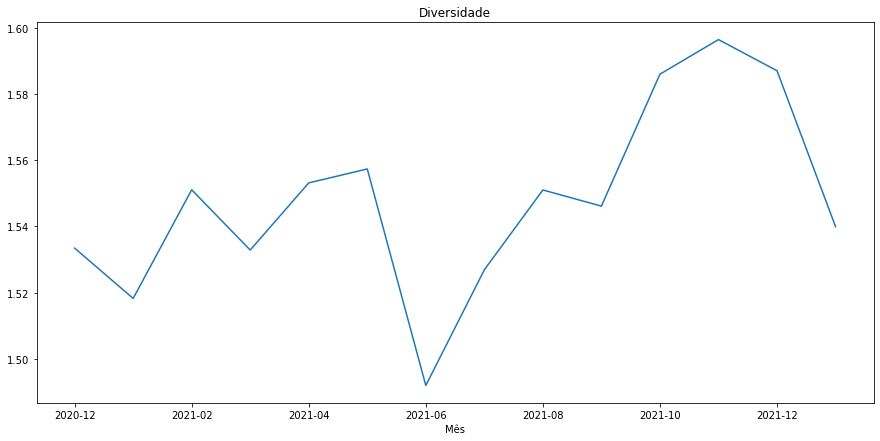

In [43]:
metrics_calculator.calculateDiversity(df, ['yyyy-mm']).plot.line(title = 'Diversidade', xlabel='Mês', figsize=(15,7))

Cálculo da diversidade ao longo do tempo e agrupado por grupo poítico.

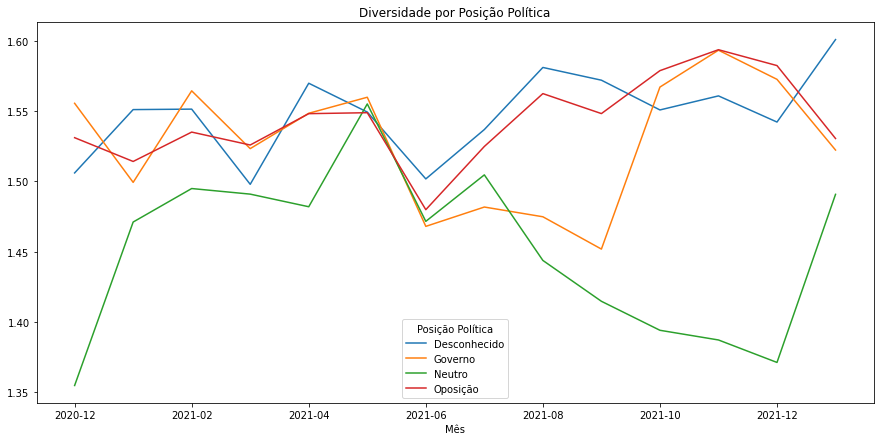

In [44]:
metrics_calculator.calculateDiversity(df, ['yyyy-mm', 'government_or_opposition_position']).unstack(level=1).plot.line(title = 'Diversidade por Posição Política', xlabel='Mês', figsize=(15,7))
plt.legend(title='Posição Política')

Cálculo da diversidade ao longo do tempo para os maiores partidos.

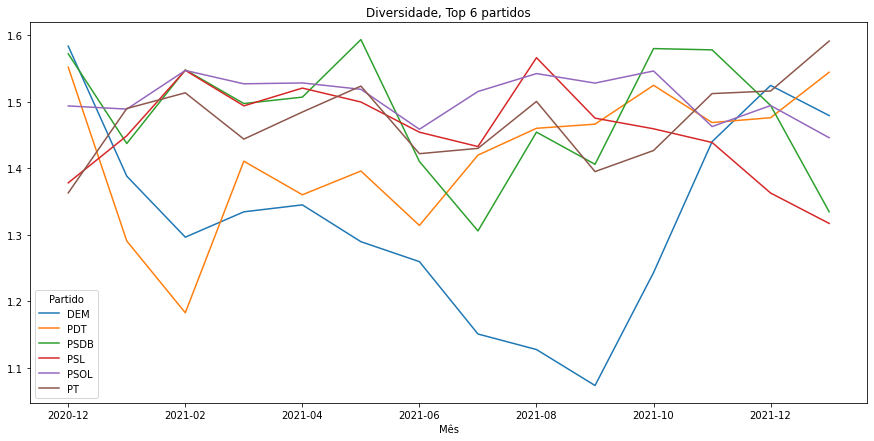

In [45]:
metrics_calculator.calculateDiversity(df[df['party'].isin(top3_parties_government + top3_parties_opposition)], ['yyyy-mm', 'party']).unstack(level=1).plot.line(title = 'Diversidade, Top 6 partidos', xlabel='Mês', figsize=(15,7))
plt.legend(title='Partido')

Cálculo da diversidade ao longo do tempo para os maiores autores.

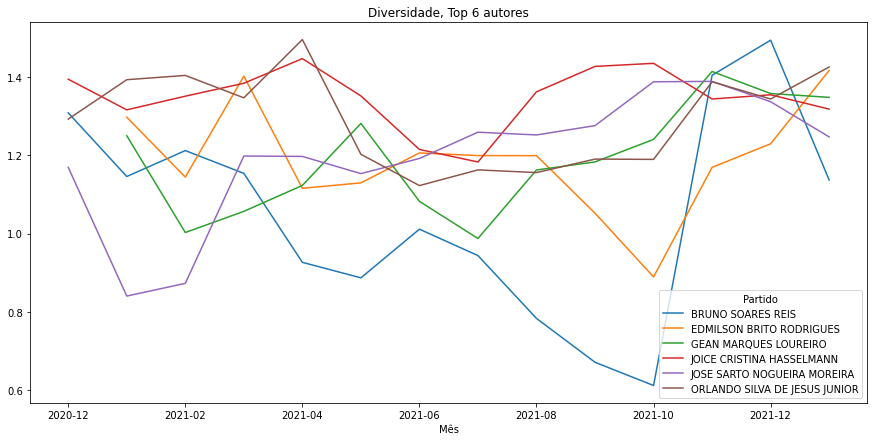

In [46]:
metrics_calculator.calculateDiversity(df[df['author.name'].isin(top3_authors_government + top3_authors_opposition)], ['yyyy-mm', 'author.name']).unstack(level=1).plot.line(title = 'Diversidade, Top 6 autores', xlabel='Mês', figsize=(15,7))
plt.legend(title='Partido')

## Coesão

Cálculo da coesão ao longo do tempo (por mês). Filtrando os 6 maiores autores.

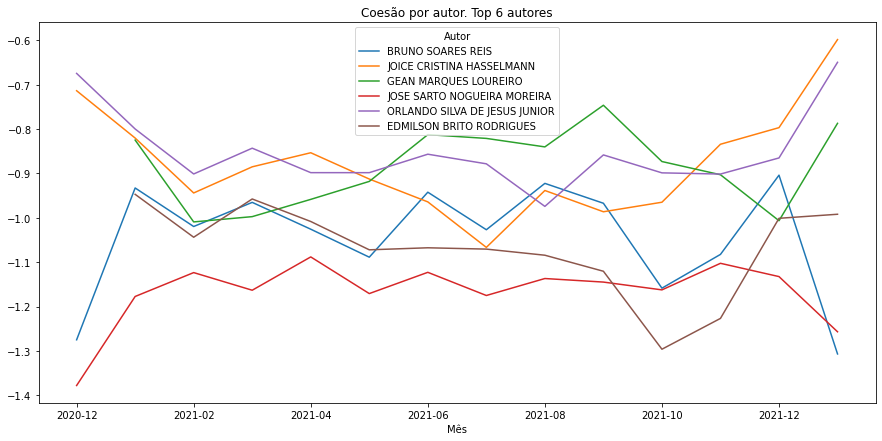

In [47]:
s = metrics_calculator.calculateCohesion(df, 'yyyy-mm', 'author.name', 'government_or_opposition_position')
s[s.index.get_level_values('author.name').isin(top3_authors_government + top3_authors_opposition)].unstack(0).droplevel('government_or_opposition_position').T.plot \
    .line(figsize=(15,7), title='Coesão por autor. Top 6 autores', xlabel='Mês')
plt.legend(title='Autor')

Cálculo da coesão ao longo do tempo (por mês). Filtrando os 6 maiores partidos.

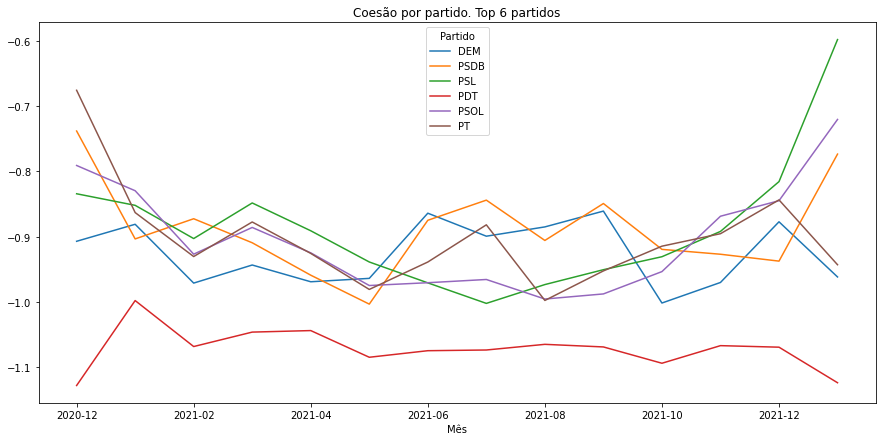

In [48]:
s = metrics_calculator.calculateCohesion(df, 'yyyy-mm', 'party', 'government_or_opposition_position')
s[s.index.get_level_values('party').isin(top3_parties_government + top3_parties_opposition)].unstack(0).droplevel('government_or_opposition_position').T.plot \
    .line(figsize=(15,7),  title='Coesão por partido. Top 6 partidos', xlabel='Mês')
plt.legend(title='Partido')

## Dissonância

Cálculo da dissonância por autor, para os 6 maiores autores selecionados.

<AxesSubplot:title={'center':'Dissonância por autor. Top 6 autores'}, ylabel='Autor, Grupo'>

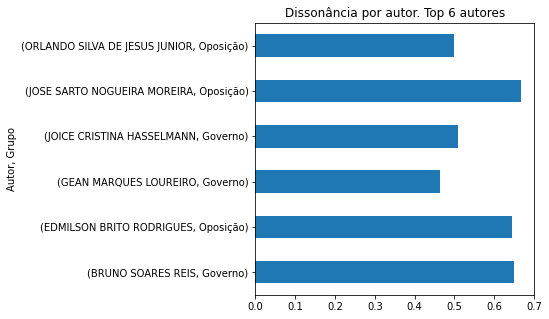

In [49]:
dissonance_by_author = metrics_calculator.calculateDissonance(df, 'author.name', 'government_or_opposition_position')
dissonance_by_author[dissonance_by_author.index.get_level_values('author.name').isin(top3_authors_government + top3_authors_opposition)].plot.barh(title='Dissonância por autor. Top 6 autores', ylabel='Autor, Grupo', figsize=(5,5))

Cálculo da dissonância por partido, para os 6 maiores partidos selecionados.

<AxesSubplot:title={'center':'Dissonância por partido. Top 6 partidos'}, ylabel='Partido, Grupo'>

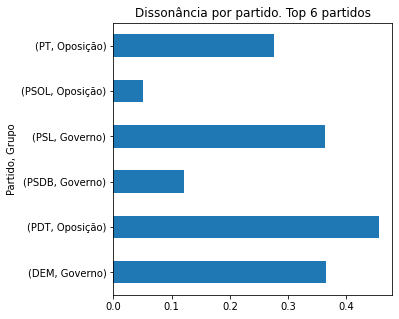

In [50]:
dissonance_by_party = metrics_calculator.calculateDissonance(df, 'party', 'government_or_opposition_position')
dissonance_by_party[dissonance_by_party.index.get_level_values('party').isin(top3_parties_government + top3_parties_opposition)].plot.barh(title='Dissonância por partido. Top 6 partidos', ylabel='Partido, Grupo', figsize=(5,5))

## Coerência

Cálculo da coerência por autor, para os 6 maiores autores selecionados.

<AxesSubplot:title={'center':'Coerência por autor. Top 6 autores'}, ylabel='Autor'>

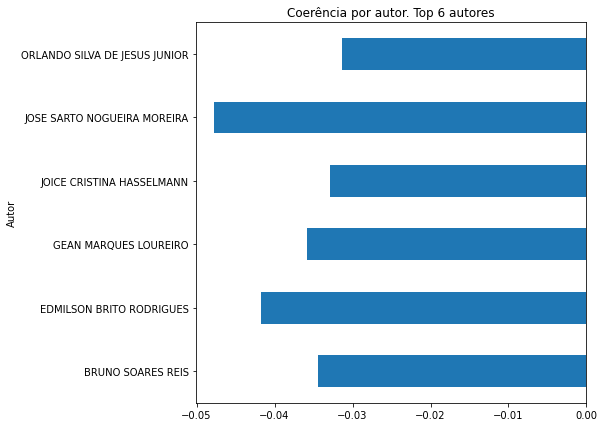

In [51]:
metrics_calculator.calculateCoherence(df[df['author.name'].isin(top3_authors_government + top3_authors_opposition)], ['author.name']).plot.barh(title = 'Coerência por autor. Top 6 autores', ylabel='Autor', figsize=(7,7))

Cálculo da coerência por partido, para os 6 maiores autores selecionados.

<AxesSubplot:title={'center':'Coerência por partido. Top 6 partidos'}, ylabel='Partido'>

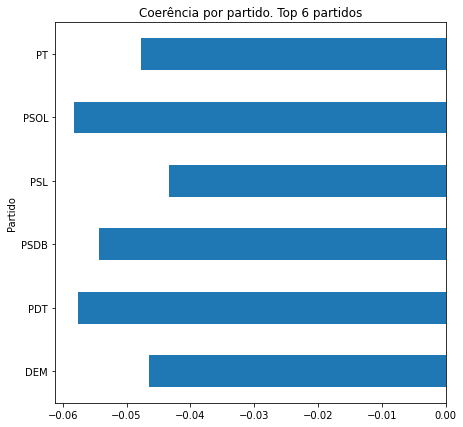

In [52]:
metrics_calculator.calculateCoherence(df[df['party'].isin(top3_parties_government + top3_parties_opposition)], ['party']).plot.barh(title = 'Coerência por partido. Top 6 partidos', ylabel='Partido', figsize=(7,7))